In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 percent More sell CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


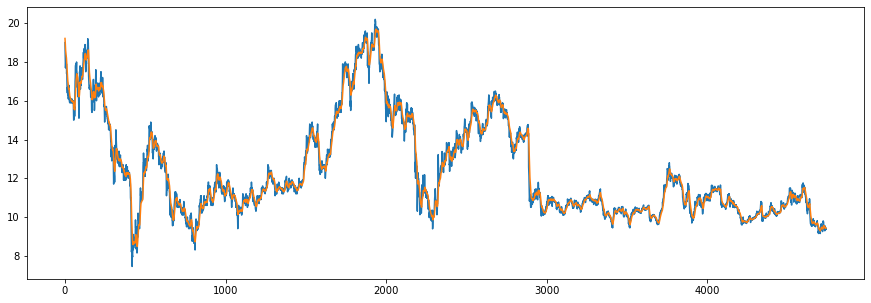

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


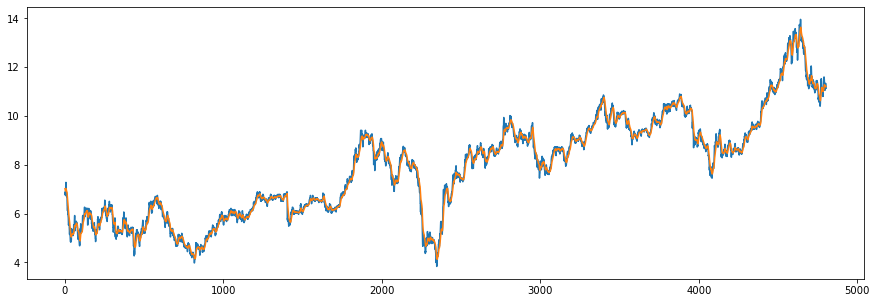

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


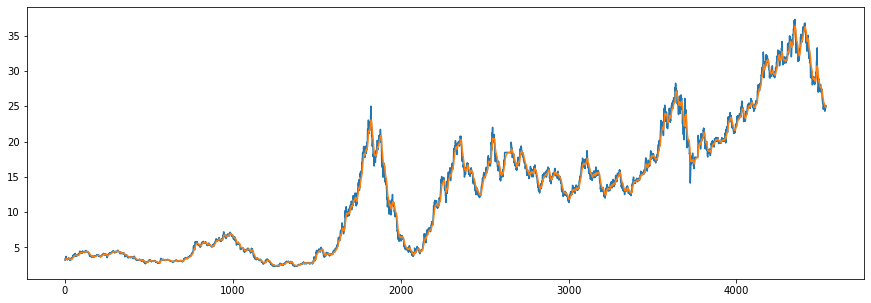

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


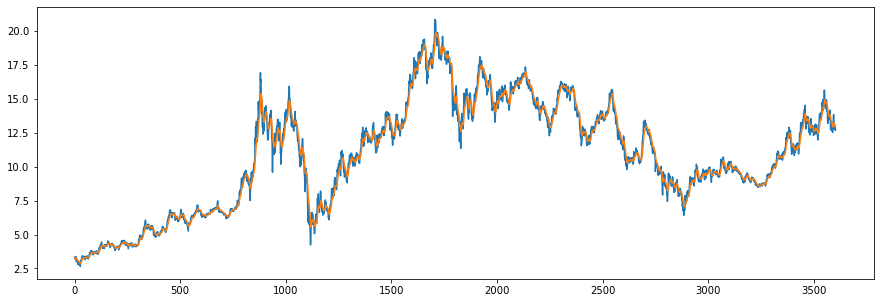

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


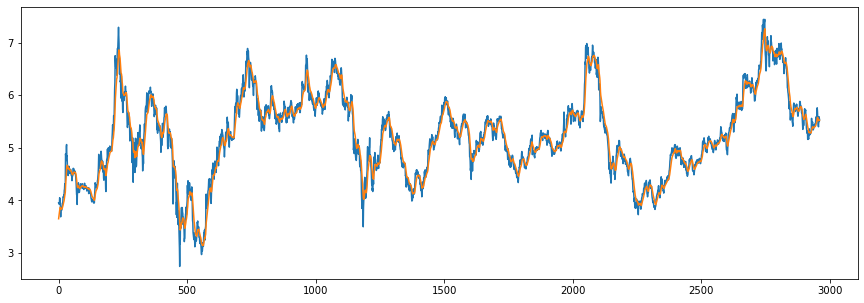

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


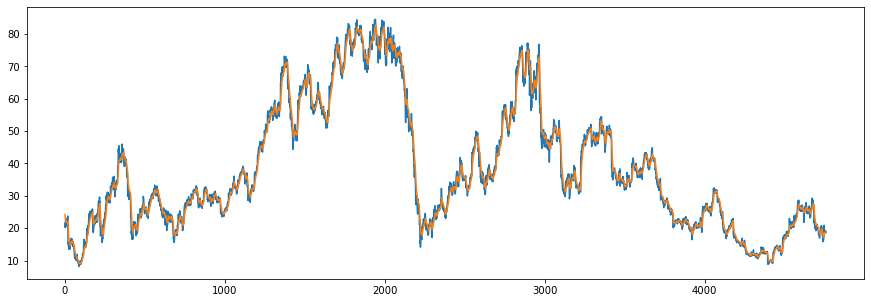

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


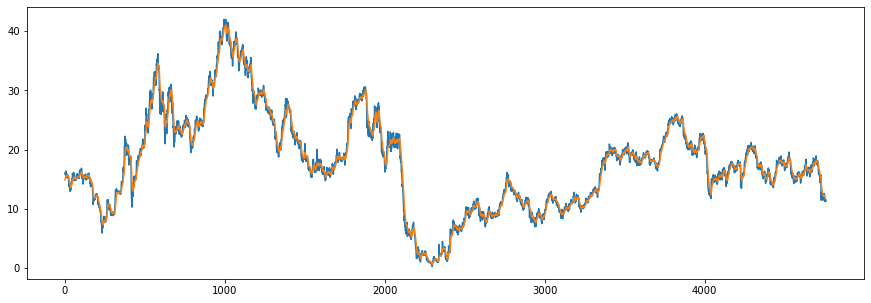

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


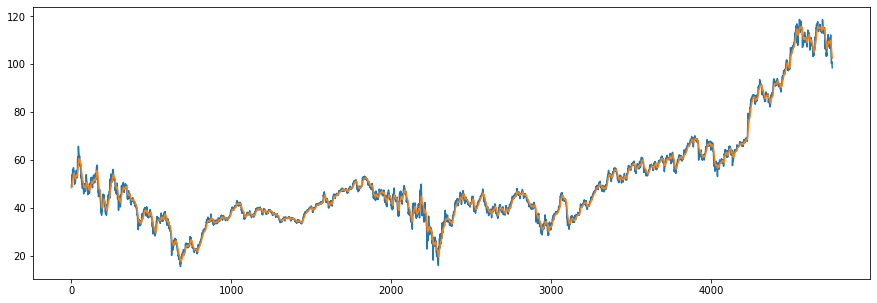

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


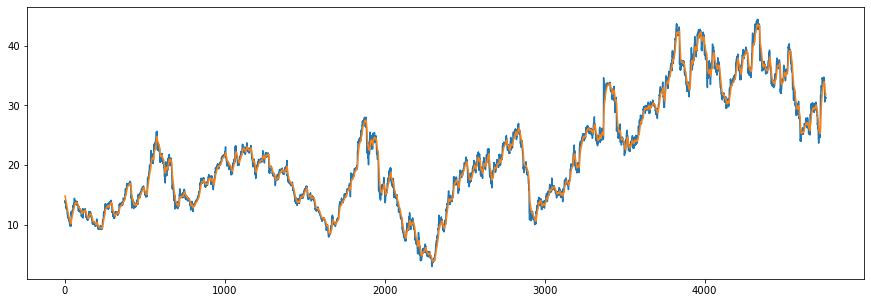

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


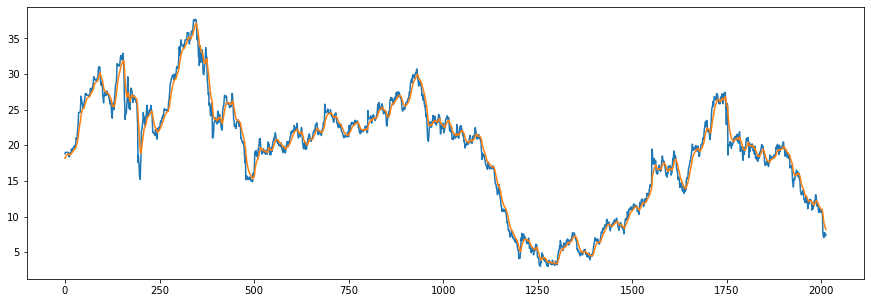

In [10]:
sequential_data = []
labels = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(41550, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1845]
class_1 = class_1[0:1384]
class_2 = class_2[0:1384]

class_0_labels = class_0_labels[0:1845]
class_1_labels = class_1_labels[0:1384]
class_2_labels = class_2_labels[0:1384]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(4613, 64, 64, 1)


Counter({0.0: 1845, 1.0: 1384, 2.0: 1384})

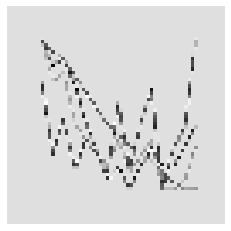

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.8333333333333334, 1: 1.1111111111111112, 2: 1.1111111111111112}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.4959 - accuracy: 0.2891 - mse: 6.1184 - weighted_accuracy: 0.3022 - weighted_mse: 6.1539WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 43ms/step - loss: 0.2329 - accuracy: 0.3079 - mse: 1.5858 - weighted_accuracy: 0.3173 - weighted_mse: 1.5825 - val_loss: 0.2005 - val_accuracy: 0.3012 - val_mse: 0.8961 - val_weighted_accuracy: 0.3012 - val_weighted_mse: 0.8961
Epoch 2/20
29/29 [==============================] - 1s 21ms/step - loss: 0.2034 - accuracy: 0.3290 - mse: 1.1714 - weighted_accuracy: 0.3354 - weighted_mse: 1.1673 - val_loss: 0.1986

Shares owned at the moment: 0
Cash capital at the moment: $131.7561563590616


Share price: $0.3724161374520112
Shares owned at the moment: 352
Cash capital at the moment: $0.30517715490012165


Price increase from previously bought: -16.448932698772655%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $109.83184434360822


Share price: $0.305302417212735
Shares owned at the moment: 358
Cash capital at the moment: $0.23300875170315294


Price increase from previously bought: -0.27424582398405395%
Share price: $0.305302417212735
Shares owned at the moment: 0
Cash capital at the moment: $109.23070388411634


Share price: $0.2516111850013243
Shares owned at the moment: 432
Cash capital at the moment: $0.2357578757626584


Price increase from previously bought: 15.685962995578251%
Share price: $0.2918792891348947
Shares owned at the moment: 0
Cash capital at the moment: $125.9808581865449




Capital at the end of test period: $125.9808581865449
pr


Price increase from previously bought: -78.10541761814493%
Share price: $0.14496889442240968
Shares owned at the moment: 0
Cash capital at the moment: $37.404310422672935


Share price: $0.611226670816807
Shares owned at the moment: 61
Cash capital at the moment: $0.01695022881818886


Price increase from previously bought: 2.7287075763249957%
Share price: $0.629631998754957
Shares owned at the moment: 0
Cash capital at the moment: $38.31888138507942


Share price: $0.7277914074535181
Shares owned at the moment: 52
Cash capital at the moment: $0.36965402623062005


Price increase from previously bought: 4.769580864608103%
Share price: $0.7646008931773667
Shares owned at the moment: 0
Cash capital at the moment: $40.01956254372933


Share price: $0.6419016323041646
Shares owned at the moment: 62
Cash capital at the moment: $0.11221711256326472


Price increase from previously bought: -95.58704284032893%
Share price: $0.028404742861924286
Shares owned at the moment: 0
Cash capital at th

7/7 [==============================] - 0s 13ms/step - loss: 0.1946 - accuracy: 0.1090 - mse: 1.1175 - weighted_accuracy: 0.1090 - weighted_mse: 1.1175
Test loss: 0.19462384283542633
Test accuracy: 0.10900473594665527


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 95
actual holds but predicted sell: 84
actual predicted holds: 15
Percentage buys correct: 3.883495145631068%
Percentage sells correct: 4.395604395604396%
Percentage holds correct: 88.23529411764706%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 47.57281553398058%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 70.58823529411765%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price increase from

Shares owned at the moment: 0
Cash capital at the moment: $53.70741686901306


Share price: $0.39215487526253145
Shares owned at the moment: 136
Cash capital at the moment: $0.22768790996059352


Price increase from previously bought: -1.5585877229250422%
Share price: $0.3871044152150227
Shares owned at the moment: 0
Cash capital at the moment: $52.72911132791326


Share price: $0.4174073360513051
Shares owned at the moment: 125
Cash capital at the moment: $0.40971054973248755


Price increase from previously bought: -21.591754741474045%
Share price: $0.3281817926395769
Shares owned at the moment: 0
Cash capital at the moment: $41.31962213845975


Share price: $0.2440067092753575
Shares owned at the moment: 168
Cash capital at the moment: $0.21376388051447748


Price increase from previously bought: -9.90691696404613%
Share price: $0.22043770841054844
Shares owned at the moment: 0
Cash capital at the moment: $37.14545667220094


Share price: $0.1598316259111383
Shares owned at the mome

7/7 [==============================] - 0s 7ms/step - loss: 0.1927 - accuracy: 0.1279 - mse: 1.0934 - weighted_accuracy: 0.1279 - weighted_mse: 1.0934
Test loss: 0.1927274465560913
Test accuracy: 0.1278538852930069


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 88
actual holds but predicted sell: 100
actual predicted holds: 9
Percentage buys correct: 8.24742268041237%
Percentage sells correct: 9.821428571428571%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 48.214285714285715%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously bo

7/7 [==============================] - 0s 7ms/step - loss: 0.1935 - accuracy: 0.1689 - mse: 1.0994 - weighted_accuracy: 0.1689 - weighted_mse: 1.0994
Test loss: 0.1934894174337387
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 80
actual holds but predicted sell: 99
actual predicted holds: 18
Percentage buys correct: 10.869565217391305%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 94.73684210526316%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.54945054945055%
Percentage high sells correct: 54.629629629629626%
Percentage mid holds correct: 89.47368421052632%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pri

Epoch 7/20
29/29 [==============================] - 0s 17ms/step - loss: 0.1789 - accuracy: 0.5377 - mse: 1.3011 - weighted_accuracy: 0.5233 - weighted_mse: 1.3054 - val_loss: 0.1694 - val_accuracy: 0.5753 - val_mse: 1.0693 - val_weighted_accuracy: 0.5753 - val_weighted_mse: 1.0693
Epoch 8/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1781 - accuracy: 0.5306 - mse: 1.3007 - weighted_accuracy: 0.5164 - weighted_mse: 1.3037 - val_loss: 0.1676 - val_accuracy: 0.5818 - val_mse: 1.1228 - val_weighted_accuracy: 0.5818 - val_weighted_mse: 1.1228
Epoch 9/20
29/29 [==============================] - 1s 19ms/step - loss: 0.1778 - accuracy: 0.5428 - mse: 1.3231 - weighted_accuracy: 0.5286 - weighted_mse: 1.3249 - val_loss: 0.1679 - val_accuracy: 0.5850 - val_mse: 1.0692 - val_weighted_accuracy: 0.5850 - val_weighted_mse: 1.0692
Epoch 10/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1761 - accuracy: 0.5412 - mse: 1.3198 - weighted_accuracy: 0.5268 - weighte

Share price: $0.3724161374520112
Shares owned at the moment: 0
Cash capital at the moment: $16.047315339450158


Share price: $0.42610736966342366
Shares owned at the moment: 37
Cash capital at the moment: $0.2379862370402286


Price increase from previously bought: -17.55224352141275%
Share price: $0.352282085385226
Shares owned at the moment: 0
Cash capital at the moment: $13.236578694105642


Share price: $0.3724161374520112
Shares owned at the moment: 35
Cash capital at the moment: $0.16616883005549354


Price increase from previously bought: -16.448932698772655%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $11.056604488023629


Share price: $0.305302417212735
Shares owned at the moment: 36
Cash capital at the moment: $0.035492529061109224


Price increase from previously bought: -0.27424582398405395%
Share price: $0.305302417212735
Shares owned at the moment: 0
Cash capital at the moment: $10.996154609415507


Share price: $0.251611185

7/7 [==============================] - 0s 7ms/step - loss: 0.2055 - accuracy: 0.0963 - mse: 1.2627 - weighted_accuracy: 0.0963 - weighted_mse: 1.2627
Test loss: 0.2055293619632721
Test accuracy: 0.09633027762174606


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 96
actual holds but predicted sell: 99
actual predicted holds: 6
Percentage buys correct: 6.796116504854369%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 75.0%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 55.33980582524272%
Percentage high sells correct: 55.660377358490564%
Percentage mid holds correct: 62.5%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price increase from previously bo

Share price: $0.4215853104507723
Shares owned at the moment: 240
Cash capital at the moment: $0.370261142938503


Price increase from previously bought: -6.043737625926893%
Share price: $0.3971950913688269
Shares owned at the moment: 0
Cash capital at the moment: $95.43493431115353


Share price: $0.36670717213922077
Shares owned at the moment: 259
Cash capital at the moment: $0.19658954373919357


Price increase from previously bought: -18.514688715818217%
Share price: $0.2996342150410418
Shares owned at the moment: 0
Cash capital at the moment: $77.58843676970605


Share price: $0.2539023361966335
Shares owned at the moment: 304
Cash capital at the moment: $0.1898642128690824


Price increase from previously bought: -19.433841036070586%
Share price: $0.20512189803274183
Shares owned at the moment: 0
Cash capital at the moment: $62.37543930806723


Share price: $0.2447560767294903
Shares owned at the moment: 254
Cash capital at the moment: $0.036433699181145585


Price increase from p

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2034 - accuracy: 0.1174 - mse: 1.2303 - weighted_accuracy: 0.1174 - weighted_mse: 1.2303
Test loss: 0.20341728627681732
Test accuracy: 0.11737088859081268


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 107
actual holds but predicted sell: 75
actual predicted holds: 11
Percentage buys correct: 5.982905982905983%
Percentage sells correct: 8.235294117647058%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.00854700854701%
Percentage high sells correct: 54.76190476190476%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment

Price increase from previously bought: 14.434111045417609%
Share price: $0.2953502961857881
Shares owned at the moment: 0
Cash capital at the moment: $520.342216156606


Share price: $0.25789822288527264
Shares owned at the moment: 2012
Cash capital at the moment: $0.02404084421323205


Price increase from previously bought: 49.1821917104309%
Share price: $0.3857962513910287
Shares owned at the moment: 0
Cash capital at the moment: $774.1114879840163


Share price: $0.40082800814450237
Shares owned at the moment: 1925
Cash capital at the moment: $0.3956890377343143


Price increase from previously bought: 15.95321381252841%
Share price: $0.46605108293688047
Shares owned at the moment: 0
Cash capital at the moment: $895.076865770932


Share price: $0.44490453536006425
Shares owned at the moment: 2006
Cash capital at the moment: $0.1440519693293254


Price increase from previously bought: -17.749439580535963%
Share price: $0.3669427989678449
Shares owned at the moment: 0
Cash capital at 

7/7 [==============================] - 0s 6ms/step - loss: 0.2044 - accuracy: 0.0917 - mse: 1.2195 - weighted_accuracy: 0.0917 - weighted_mse: 1.2195
Test loss: 0.2044401466846466
Test accuracy: 0.0917431190609932


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 99
actual holds but predicted sell: 95
actual predicted holds: 8
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 6.730769230769231%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 44.76190476190476%
Percentage high sells correct: 50.48543689320388%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price inc

Share price: $0.5863157623131194
Shares owned at the moment: 96
Cash capital at the moment: $0.028810130131503797


Price increase from previously bought: -1.1694492513874666%
Share price: $0.581052609536787
Shares owned at the moment: 0
Cash capital at the moment: $55.656462756745334


Share price: $0.6678946930880041
Shares owned at the moment: 83
Cash capital at the moment: $0.0687562667436552


Price increase from previously bought: -10.29396849474672%
Share price: $0.6007894638188991
Shares owned at the moment: 0
Cash capital at the moment: $49.79715156859561


Share price: $0.637631595994957
Shares owned at the moment: 77
Cash capital at the moment: $0.564500186531987


Price increase from previously bought: -6.859523785502153%
Share price: $0.5955263110425664
Shares owned at the moment: 0
Cash capital at the moment: $46.293923440446335


Share price: $0.5850000054899009
Shares owned at the moment: 78
Cash capital at the moment: $0.5384405110564785


Price increase from previousl

29/29 [==============================] - 1s 19ms/step - loss: 0.1621 - accuracy: 0.6211 - mse: 1.4471 - weighted_accuracy: 0.6079 - weighted_mse: 1.4494 - val_loss: 0.1592 - val_accuracy: 0.5948 - val_mse: 1.2447 - val_weighted_accuracy: 0.5948 - val_weighted_mse: 1.2447
Epoch 13/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1614 - accuracy: 0.6165 - mse: 1.4487 - weighted_accuracy: 0.6051 - weighted_mse: 1.4506 - val_loss: 0.1599 - val_accuracy: 0.6100 - val_mse: 1.2088 - val_weighted_accuracy: 0.6100 - val_weighted_mse: 1.2088
Epoch 14/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1622 - accuracy: 0.6249 - mse: 1.4231 - weighted_accuracy: 0.6146 - weighted_mse: 1.4263 - val_loss: 0.1587 - val_accuracy: 0.6165 - val_mse: 1.2453 - val_weighted_accuracy: 0.6165 - val_weighted_mse: 1.2453
Epoch 15/20
29/29 [==============================] - 1s 19ms/step - loss: 0.1612 - accuracy: 0.6190 - mse: 1.4491 - weighted_accuracy: 0.6067 - weighted_mse: 1.

7/7 [==============================] - 0s 6ms/step - loss: 0.2032 - accuracy: 0.1767 - mse: 1.3301 - weighted_accuracy: 0.1767 - weighted_mse: 1.3301
Test loss: 0.20321860909461975
Test accuracy: 0.17674419283866882


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 107
actual holds but predicted sell: 65
actual predicted holds: 26
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 89.65517241379311%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.49122807017544%
Percentage high sells correct: 59.15492957746479%
Percentage mid holds correct: 82.75862068965517%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price

Price increase from previously bought: 23.21198530018631%
Share price: $0.9977297813745658
Shares owned at the moment: 0
Cash capital at the moment: $171.7504441533915


Share price: $0.611226670816807
Shares owned at the moment: 280
Cash capital at the moment: $0.13633178815658198


Price increase from previously bought: -27.300158212836433%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $124.55642119464905


Share price: $0.40263763479424886
Shares owned at the moment: 308
Cash capital at the moment: $0.20299560134965589


Price increase from previously bought: -51.93767414125905%
Share price: $0.19404918384791725
Shares owned at the moment: 0
Cash capital at the moment: $59.80578456778898


Share price: $0.5498773329183202
Shares owned at the moment: 108
Cash capital at the moment: $0.2557190447336595


Price increase from previously bought: 13.077397091513854%
Share price: $0.6234968894422404
Shares owned at the moment: 0
Cash capital at 

7/7 [==============================] - 0s 10ms/step - loss: 0.2181 - accuracy: 0.1137 - mse: 1.4213 - weighted_accuracy: 0.1137 - weighted_mse: 1.4213
Test loss: 0.21808932721614838
Test accuracy: 0.11374407261610031


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 104
actual holds but predicted sell: 76
actual predicted holds: 14
Percentage buys correct: 3.6363636363636362%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 82.3529411764706%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 51.81818181818182%
Percentage high sells correct: 55.95238095238095%
Percentage mid holds correct: 68.75%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price increase 


Capital at the end of test period: $28.560300089333534
profit gained: -71.43969991066646%


Capital at the end of test period if Buy and Hold: $15.710112504960433
profit gained: -84.28988749503957%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.176744      5.263158       8.333333      89.655172   
1       0.218605      7.692308      11.538462      90.909091   
2       0.164319      6.250000       8.750000     100.000000   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         46.491228           59.154930          82.758621     -79.535303   
1         53.846154           57.142857          87.878788     -39.703697   
2         44.642857           51.898734          90.476190     -71.439700   

   buy_n_hold profit  
0         -78.238355  
1         -24.562920  
2         -84.289887  


JPM


Non-Recession Test


7/7 [==============================] - 0s 9ms/step - loss: 0.2248 - accuracy: 0.1101 - mse: 1.4631 - weighted_accu

Shares owned at the moment: 0
Cash capital at the moment: $17.670027839314624


Share price: $0.15380198713573123
Shares owned at the moment: 114
Cash capital at the moment: $0.08838438287421013


Price increase from previously bought: 74.38508255722193%
Share price: $0.2689452934774563
Shares owned at the moment: 0
Cash capital at the moment: $30.663833489799046


Share price: $0.15074958249863268
Shares owned at the moment: 202
Cash capital at the moment: $0.1286764319972491


Price increase from previously bought: 89.02197770874945%
Share price: $0.28573345429272146
Shares owned at the moment: 0
Cash capital at the moment: $57.68810926526737


Share price: $0.2299423597120367
Shares owned at the moment: 250
Cash capital at the moment: $0.0444339649561698


Price increase from previously bought: -13.73311999906427%
Share price: $0.19890960079779396
Shares owned at the moment: 0
Cash capital at the moment: $49.63508381385618


Share price: $0.2947210542304133
Shares owned at the momen

7/7 [==============================] - 0s 11ms/step - loss: 0.2072 - accuracy: 0.2100 - mse: 1.3545 - weighted_accuracy: 0.2100 - weighted_mse: 1.3545
Test loss: 0.20717279613018036
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 90
actual predicted holds: 29
Percentage buys correct: 10.227272727272727%
Percentage sells correct: 8.080808080808081%
Percentage holds correct: 90.625%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.32183908045977%
Percentage high sells correct: 58.58585858585859%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previ

Epoch 3/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1560 - accuracy: 0.6390 - mse: 1.4840 - weighted_accuracy: 0.6290 - weighted_mse: 1.4837 - val_loss: 0.1570 - val_accuracy: 0.5948 - val_mse: 1.2708 - val_weighted_accuracy: 0.5948 - val_weighted_mse: 1.2708
Epoch 4/20
29/29 [==============================] - 1s 20ms/step - loss: 0.1566 - accuracy: 0.6423 - mse: 1.4830 - weighted_accuracy: 0.6306 - weighted_mse: 1.4845 - val_loss: 0.1572 - val_accuracy: 0.6035 - val_mse: 1.3067 - val_weighted_accuracy: 0.6035 - val_weighted_mse: 1.3067
Epoch 5/20
29/29 [==============================] - 1s 19ms/step - loss: 0.1566 - accuracy: 0.6377 - mse: 1.4830 - weighted_accuracy: 0.6265 - weighted_mse: 1.4870 - val_loss: 0.1561 - val_accuracy: 0.6002 - val_mse: 1.3678 - val_weighted_accuracy: 0.6002 - val_weighted_mse: 1.3678
Epoch 6/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1541 - accuracy: 0.6469 - mse: 1.5091 - weighted_accuracy: 0.6371 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.2111 - accuracy: 0.2140 - mse: 1.4236 - weighted_accuracy: 0.2140 - weighted_mse: 1.4236
Test loss: 0.21110311150550842
Test accuracy: 0.21395349502563477


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 106
actual holds but predicted sell: 58
actual predicted holds: 34
Percentage buys correct: 5.357142857142857%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 89.47368421052632%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.535714285714285%
Percentage high sells correct: 59.375%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.4772492352987143


Price increase fro



Price increase from previously bought: 23.21198530018631%
Share price: $0.9977297813745658
Shares owned at the moment: 0
Cash capital at the moment: $204.32652420364292


Share price: $0.611226670816807
Shares owned at the moment: 333
Cash capital at the moment: $0.22831199784567957


Price increase from previously bought: -27.300158212836433%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $148.1993468991385


Share price: $0.40263763479424886
Shares owned at the moment: 367
Cash capital at the moment: $0.024972896733089556


Price increase from previously bought: -51.93767414125905%
Share price: $0.19404918384791725
Shares owned at the moment: 0
Cash capital at the moment: $71.04517923012021


Share price: $0.5498773329183202
Shares owned at the moment: 128
Cash capital at the moment: $0.4673237953879692


Price increase from previously bought: 9.739406780570171%
Share price: $0.6050915615040904
Shares owned at the moment: 0
Cash capital a

   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.213953      5.357143       9.230769      89.473684   
1       0.232558      5.050505      12.162162      85.714286   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         45.535714           59.375000          84.210526     -78.932448   
1         52.525253           60.273973          80.952381       2.727637   

   buy_n_hold profit  
0         -78.238355  
1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2280 - accuracy: 0.1469 - mse: 1.5294 - weighted_accuracy: 0.1469 - weighted_mse: 1.5294
Test loss: 0.22803132236003876
Test accuracy: 0.14691942930221558


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 100
actu


Share price: $0.4207744164504643
Shares owned at the moment: 87
Cash capital at the moment: $0.07223738157382797


Price increase from previously bought: 11.296716902307203%
Share price: $0.4695959583796625
Shares owned at the moment: 0
Cash capital at the moment: $40.81473492756213


Share price: $0.4190908762508847
Shares owned at the moment: 97
Cash capital at the moment: $0.05112743998638791


Price increase from previously bought: 2.5299531147981114%
Share price: $0.4308753365454818
Shares owned at the moment: 0
Cash capital at the moment: $41.731099088874615


Share price: $0.39720533531004043
Shares owned at the moment: 104
Cash capital at the moment: $0.3081434907317373


Price increase from previously bought: 20.43678352011018%
Share price: $0.4796968784746798
Shares owned at the moment: 0
Cash capital at the moment: $50.059425544854676


Share price: $0.41404041620337595
Shares owned at the moment: 120
Cash capital at the moment: $0.23794226310244682


Price increase from pr

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2126 - accuracy: 0.2374 - mse: 1.4217 - weighted_accuracy: 0.2374 - weighted_mse: 1.4217
Test loss: 0.21262452006340027
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 88
actual holds but predicted sell: 76
actual predicted holds: 33
Percentage buys correct: 8.24742268041237%
Percentage sells correct: 12.5%
Percentage holds correct: 97.05882352941177%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.54639175257732%
Percentage high sells correct: 59.09090909090909%
Percentage mid holds correct: 93.93939393939394%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: 

7/7 [==============================] - 0s 9ms/step - loss: 0.2202 - accuracy: 0.1697 - mse: 1.4756 - weighted_accuracy: 0.1697 - weighted_mse: 1.4756
Test loss: 0.2201826572418213
Test accuracy: 0.16972477734088898


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 92
actual holds but predicted sell: 84
actual predicted holds: 26
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 89.65517241379311%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price 



Price increase from previously bought: 7.127798787202977%
Share price: $0.6284210472655098
Shares owned at the moment: 0
Cash capital at the moment: $199.4645070124173


Share price: $0.6836842141587314
Shares owned at the moment: 290
Cash capital at the moment: $0.6508467455936113


Price increase from previously bought: -0.27424582398404285%
Share price: $0.6836842141587314
Shares owned at the moment: 0
Cash capital at the moment: $198.3740306908341


Share price: $0.5784210331486206
Shares owned at the moment: 342
Cash capital at the moment: $0.010032372329561667


Price increase from previously bought: 10.841687979461433%
Share price: $0.6428947487712893
Shares owned at the moment: 0
Cash capital at the moment: $219.2753939408911


Share price: $0.5902631582662341
Shares owned at the moment: 370
Cash capital at the moment: $0.2774326188485645


Price increase from previously bought: 17.73240901438802%
Share price: $0.6968420960995632
Shares owned at the moment: 0
Cash capital at 

29/29 [==============================] - 1s 18ms/step - loss: 0.1381 - accuracy: 0.7041 - mse: 1.6471 - weighted_accuracy: 0.6950 - weighted_mse: 1.6480 - val_loss: 0.1559 - val_accuracy: 0.6013 - val_mse: 1.4518 - val_weighted_accuracy: 0.6013 - val_weighted_mse: 1.4518
Epoch 15/20
29/29 [==============================] - 1s 20ms/step - loss: 0.1368 - accuracy: 0.6984 - mse: 1.6448 - weighted_accuracy: 0.6908 - weighted_mse: 1.6386 - val_loss: 0.1567 - val_accuracy: 0.5905 - val_mse: 1.4330 - val_weighted_accuracy: 0.5905 - val_weighted_mse: 1.4330
Epoch 16/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1360 - accuracy: 0.7041 - mse: 1.6465 - weighted_accuracy: 0.6968 - weighted_mse: 1.6400 - val_loss: 0.1547 - val_accuracy: 0.6121 - val_mse: 1.5747 - val_weighted_accuracy: 0.6121 - val_weighted_mse: 1.5747
Epoch 17/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1363 - accuracy: 0.7019 - mse: 1.6528 - weighted_accuracy: 0.6936 - weighted_mse: 1.

Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.2397 - accuracy: 0.1674 - mse: 1.7240 - weighted_accuracy: 0.1674 - weighted_mse: 1.7240
Test loss: 0.23968812823295593
Test accuracy: 0.16744185984134674


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 116
actual holds but predicted sell: 58
actual predicted holds: 24
Percentage buys correct: 5.645161290322581%
Percentage sells correct: 7.8125%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.354838709677416%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.4772492352987143




Share price: $0.73392593169001
Shares owned at the moment: 223
Cash capital at the moment: $0.5477804332616074


Price increase from previously bought: 6.394777120695361%
Share price: $0.7830062211155175
Shares owned at the moment: 0
Cash capital at the moment: $174.67798917692292


Share price: $0.8075460732901576
Shares owned at the moment: 215
Cash capital at the moment: $0.5781218037062104


Price increase from previously bought: 21.69677954335214%
Share price: $0.9854601478253582
Shares owned at the moment: 0
Cash capital at the moment: $211.86940027375647


Share price: $0.611226670816807
Shares owned at the moment: 345
Cash capital at the moment: $0.41629753802058644


Price increase from previously bought: -27.300158212836433%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $153.71962198530593


Share price: $0.40263763479424886
Shares owned at the moment: 380
Cash capital at the moment: $0.29656443513135855


Price increase from prev

Price increase from previously bought: 20.309053710626657%
Share price: $0.4276830105984313
Shares owned at the moment: 0
Cash capital at the moment: $74.78041990370713


Share price: $0.4215853104507723
Shares owned at the moment: 176
Cash capital at the moment: $0.37735797411302485


Price increase from previously bought: -6.043737625926893%
Share price: $0.3971950913688269
Shares owned at the moment: 0
Cash capital at the moment: $70.09145163080404


Share price: $0.36670717213922077
Shares owned at the moment: 190
Cash capital at the moment: $0.225484426909361


Price increase from previously bought: -1.1032993587494322%
Share price: $0.363658612819737
Shares owned at the moment: 0
Cash capital at the moment: $69.13060923746109


Share price: $0.3423169530572745
Shares owned at the moment: 201
Cash capital at the moment: $0.135685977146494


Price increase from previously bought: -6.491536847624769%
Share price: $0.3209755840491584
Shares owned at the moment: 0
Cash capital at the 

7/7 [==============================] - 0s 14ms/step - loss: 0.2452 - accuracy: 0.1596 - mse: 1.7669 - weighted_accuracy: 0.1596 - weighted_mse: 1.7669
Test loss: 0.2451619654893875
Test accuracy: 0.15962441265583038


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 109
actual holds but predicted sell: 64
actual predicted holds: 20
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 9.45945945945946%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.378151260504204%
Percentage high sells correct: 50.68493150684932%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -1.60

Price increase from previously bought: 65.28731567555946%
Share price: $0.0989171603096468
Shares owned at the moment: 0
Cash capital at the moment: $164.7952544026971


Share price: $0.1926751480928941
Shares owned at the moment: 852
Cash capital at the moment: $0.18459035556969638


Price increase from previously bought: -10.95558635747601%
Share price: $0.1720382636077813
Shares owned at the moment: 0
Cash capital at the moment: $146.35810529776631


Share price: $0.16872623102977413
Shares owned at the moment: 865
Cash capital at the moment: $0.008557934949607215


Price increase from previously bought: -17.139940539247945%
Share price: $0.1401911236593889
Shares owned at the moment: 0
Cash capital at the moment: $120.94040026491624


Share price: $0.11038224731877809
Shares owned at the moment: 1092
Cash capital at the moment: $0.07150830411227105


Price increase from previously bought: 51.97664941608178%
Share price: $0.16821656793807116
Shares owned at the moment: 0
Cash capita

Share price: $0.30235200113438254
Shares owned at the moment: 1776
Cash capital at the moment: $0.06944129212263306


Price increase from previously bought: 8.78681605120275%
Share price: $0.3298236428682695
Shares owned at the moment: 0
Cash capital at the moment: $584.2253723544006


Share price: $0.36102601575611626
Shares owned at the moment: 1613
Cash capital at the moment: $0.28898779039479905


Price increase from previously bought: 9.328392798351981%
Share price: $0.3957893764467646
Shares owned at the moment: 0
Cash capital at the moment: $636.9416292724524


Share price: $0.3947719513602499
Shares owned at the moment: 1609
Cash capital at the moment: $0.006792342029029896


Price increase from previously bought: -1.1738413887055876%
Share price: $0.3912108341798941
Shares owned at the moment: 0
Cash capital at the moment: $627.7340143989411


Share price: $0.36221305481623456
Shares owned at the moment: 1728
Cash capital at the moment: $0.10861924000107592


Price increase fr

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2404 - accuracy: 0.2009 - mse: 1.7178 - weighted_accuracy: 0.2009 - weighted_mse: 1.7178
Test loss: 0.2403869330883026
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 86
actual holds but predicted sell: 85
actual predicted holds: 26
Percentage buys correct: 10.309278350515465%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 92.85714285714286%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.041666666666664%
Percentage high sells correct: 53.191489361702125%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital a




RUNNING EPOCHS 100 - 120



Epoch 1/20
29/29 [==============================] - 1s 28ms/step - loss: 0.1328 - accuracy: 0.7238 - mse: 1.6772 - weighted_accuracy: 0.7154 - weighted_mse: 1.6746 - val_loss: 0.1558 - val_accuracy: 0.6056 - val_mse: 1.4707 - val_weighted_accuracy: 0.6056 - val_weighted_mse: 1.4707
Epoch 2/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1322 - accuracy: 0.7257 - mse: 1.6439 - weighted_accuracy: 0.7177 - weighted_mse: 1.6379 - val_loss: 0.1540 - val_accuracy: 0.6251 - val_mse: 1.5386 - val_weighted_accuracy: 0.6251 - val_weighted_mse: 1.5386
Epoch 3/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1312 - accuracy: 0.7271 - mse: 1.6947 - weighted_accuracy: 0.7188 - weighted_mse: 1.6879 - val_loss: 0.1549 - val_accuracy: 0.6165 - val_mse: 1.5584 - val_weighted_accuracy: 0.6165 - val_weighted_mse: 1.5584
Epoch 4/20
29/29 [==============================] - 1s 22ms/step - loss: 0.1317 - accuracy: 0.7271 - mse: 1.6866 - weigh

Price increase from previously bought: -0.27424582398404285%
Share price: $0.1173824644228214
Shares owned at the moment: 0
Cash capital at the moment: $32.708127616593906


Share price: $0.285167725095975
Shares owned at the moment: 114
Cash capital at the moment: $0.10960687383516898


Price increase from previously bought: 9.11391095834535%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $35.581311588359945


Share price: $0.3724161374520112
Shares owned at the moment: 95
Cash capital at the moment: $0.10448481450954716


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $27.120918630445846


Share price: $0.3589936494241448
Shares owned at the moment: 75
Cash capital at the moment: $0.12235248344125793


Price increase from previously bought: -30.104292308156577%
Share price: $0.2516111850013243
Shares owned at the moment: 0
Cash capital at 

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2900 - accuracy: 0.1422 - mse: 2.1187 - weighted_accuracy: 0.1422 - weighted_mse: 2.1187
Test loss: 0.29000556468963623
Test accuracy: 0.14220184087753296


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 95
actual holds but predicted sell: 88
actual predicted holds: 18
Percentage buys correct: 5.9405940594059405%
Percentage sells correct: 7.368421052631579%
Percentage holds correct: 81.81818181818181%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 55.445544554455445%
Percentage high sells correct: 59.57446808510638%
Percentage mid holds correct: 68.18181818181819%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156



Price increase from previously bought: 0.6467743355536681%
Share price: $0.3331706935901313
Shares owned at the moment: 0
Cash capital at the moment: $43.165358730134805


Share price: $0.2813414053524099
Shares owned at the moment: 153
Cash capital at the moment: $0.0017493149140577202


Price increase from previously bought: 23.500890362419824%
Share price: $0.3484146532049339
Shares owned at the moment: 0
Cash capital at the moment: $53.16259578993297


Share price: $0.2539023361966335
Shares owned at the moment: 208
Cash capital at the moment: $0.20567772472873003


Price increase from previously bought: 89.53644238281913%
Share price: $0.4825608581556373
Shares owned at the moment: 0
Cash capital at the moment: $100.30231141023627


Share price: $0.3545120625982474
Shares owned at the moment: 282
Cash capital at the moment: $0.05498565298555036


Price increase from previously bought: 8.302135797973541%
Share price: $0.3849999818278531
Shares owned at the moment: 0
Cash capital a

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 8ms/step - loss: 0.2681 - accuracy: 0.2207 - mse: 1.9956 - weighted_accuracy: 0.2207 - weighted_mse: 1.9956
Test loss: 0.26808497309684753
Test accuracy: 0.22065727412700653


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 100
actual holds but predicted sell: 60
actual predicted holds: 33
Percentage buys correct: 6.363636363636363%
Percentage sells correct: 10.0%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.54545454545455%
Percentage high sells correct: 50.72463768115942%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709

Price increase from previously bought: 438.59979380224183%
Share price: $0.16821656793807116
Shares owned at the moment: 0
Cash capital at the moment: $690.8291884836718


Share price: $0.429872778606591
Shares owned at the moment: 1602
Cash capital at the moment: $0.2791926297616101


Price increase from previously bought: 3.9222384193803084%
Share price: $0.4479619307717362
Shares owned at the moment: 0
Cash capital at the moment: $715.9407094400681


Share price: $0.4217197241754669
Shares owned at the moment: 1693
Cash capital at the moment: $0.00579480517274078


Price increase from previously bought: -26.000192936731747%
Share price: $0.3129299796387459
Shares owned at the moment: 0
Cash capital at the moment: $528.3393265808664


Share price: $0.2573885597935692
Shares owned at the moment: 2047
Cash capital at the moment: $0.016040133212186447


Price increase from previously bought: 14.434111045417609%
Share price: $0.2953502961857881
Shares owned at the moment: 0
Cash capital 




Capital at the end of test period: $840.7776601756791
profit gained: 740.7776601756791%


Capital at the end of test period if Buy and Hold: $68.09965200824497
profit gained: -31.90034799175503%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.195349      5.128205       7.936508      88.571429   
1       0.260465      5.263158      11.428571      86.000000   
2       0.220657      6.363636      10.000000     100.000000   
3       0.246575      9.000000      13.253012      94.444444   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         43.589744           54.838710          85.714286     -64.633764   
1         54.736842           60.869565          82.000000      19.567154   
2         44.545455           50.724638          87.878788     -68.464631   
3         51.000000           59.036145          85.714286     740.777660   

   buy_n_hold profit  
0         -78.238355  
1         -24.562920  
2         -84.289887  
3  

Share price: $0.438947359092348
Shares owned at the moment: 0
Cash capital at the moment: $59.24081925902969


Share price: $0.48894737320923726
Shares owned at the moment: 120
Cash capital at the moment: $0.40578184076217383


Price increase from previously bought: -56.094901136677834%
Share price: $0.21526317787302457
Shares owned at the moment: 0
Cash capital at the moment: $26.166326336827023


Share price: $0.1547368268326052
Shares owned at the moment: 168
Cash capital at the moment: $0.09905101495268553


Price increase from previously bought: 30.254039813304125%
Share price: $0.20210523319046308
Shares owned at the moment: 0
Cash capital at the moment: $33.95935757321649


Share price: $0.08499998980446886
Shares owned at the moment: 398
Cash capital at the moment: $0.036329142196890984


Price increase from previously bought: 78.45661922545268%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $60.40773962247216


Share price: $0.14157

29/29 [==============================] - 1s 24ms/step - loss: 0.1144 - accuracy: 0.7729 - mse: 1.9460 - weighted_accuracy: 0.7678 - weighted_mse: 1.9274 - val_loss: 0.1599 - val_accuracy: 0.6024 - val_mse: 1.7247 - val_weighted_accuracy: 0.6024 - val_weighted_mse: 1.7247
Epoch 6/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1149 - accuracy: 0.7678 - mse: 1.8970 - weighted_accuracy: 0.7614 - weighted_mse: 1.8776 - val_loss: 0.1595 - val_accuracy: 0.6262 - val_mse: 1.8449 - val_weighted_accuracy: 0.6262 - val_weighted_mse: 1.8449
Epoch 7/20
29/29 [==============================] - 1s 20ms/step - loss: 0.1140 - accuracy: 0.7661 - mse: 1.9463 - weighted_accuracy: 0.7591 - weighted_mse: 1.9254 - val_loss: 0.1581 - val_accuracy: 0.6111 - val_mse: 1.7405 - val_weighted_accuracy: 0.6111 - val_weighted_mse: 1.7405
Epoch 8/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1135 - accuracy: 0.7759 - mse: 1.9483 - weighted_accuracy: 0.7692 - weighted_mse: 1.923

Cash capital at the moment: $449.6354267561337


Share price: $0.3455705213463063
Shares owned at the moment: 1297
Cash capital at the moment: $0.19789691296250567


Price increase from previously bought: 9.409783603368549%
Share price: $0.3791277014909318
Shares owned at the moment: 0
Cash capital at the moment: $490.57427201740825


Share price: $0.285167725095975
Shares owned at the moment: 1715
Cash capital at the moment: $0.1667011943272314


Price increase from previously bought: 9.11391095834535%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $533.7980484347659


Share price: $0.3724161374520112
Shares owned at the moment: 1429
Cash capital at the moment: $0.1518856996898421


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $406.5359269941422


Share price: $0.3589936494241448
Shares owned at the moment: 1129
Cash capital at the moment

7/7 [==============================] - 0s 7ms/step - loss: 0.3407 - accuracy: 0.1560 - mse: 2.5158 - weighted_accuracy: 0.1560 - weighted_mse: 2.5158
Test loss: 0.34067192673683167
Test accuracy: 0.15596330165863037


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 85
actual holds but predicted sell: 93
actual predicted holds: 23
Percentage buys correct: 4.49438202247191%
Percentage sells correct: 7.0%
Percentage holds correct: 79.3103448275862%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 53.93258426966292%
Percentage high sells correct: 56.56565656565657%
Percentage mid holds correct: 68.96551724137932%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price increase from pre

Share price: $0.363658612819737
Shares owned at the moment: 0
Cash capital at the moment: $81.82376939345866


Share price: $0.3423169530572745
Shares owned at the moment: 238
Cash capital at the moment: $0.12828812005135148


Price increase from previously bought: -6.491536847624769%
Share price: $0.3209755840491584
Shares owned at the moment: 0
Cash capital at the moment: $76.31039860399088


Share price: $0.2721951458852663
Shares owned at the moment: 279
Cash capital at the moment: $0.15911117632111882


Price increase from previously bought: 0.8427795072113442%
Share price: $0.275243995959096
Shares owned at the moment: 0
Cash capital at the moment: $76.74100509300928


Share price: $0.2600000363442929
Shares owned at the moment: 294
Cash capital at the moment: $0.09078437840280174


Price increase from previously bought: -13.137515624788643%
Share price: $0.22646355779520433
Shares owned at the moment: 0
Cash capital at the moment: $66.48797458371546


Share price: $0.24475607672

7/7 [==============================] - 0s 9ms/step - loss: 0.3010 - accuracy: 0.2254 - mse: 2.2960 - weighted_accuracy: 0.2254 - weighted_mse: 2.2960
Test loss: 0.30101752281188965
Test accuracy: 0.22535210847854614


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 91
actual holds but predicted sell: 68
actual predicted holds: 34
Percentage buys correct: 6.930693069306931%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.554455445544555%
Percentage high sells correct: 48.05194805194805%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $0.9897979992587349
Shares owned at the moment: 100
Cash capital at the moment: $0.7480056243303466


Price increase f


Price increase from previously bought: 3.47465898809336%
Share price: $0.2953502961857881
Shares owned at the moment: 0
Cash capital at the moment: $577.260810202715


Share price: $0.3007005923715764
Shares owned at the moment: 1914
Cash capital at the moment: $0.1371388355698855


Price increase from previously bought: 2.5986339622532606%
Share price: $0.3093631155148875
Shares owned at the moment: 0
Cash capital at the moment: $590.6298091725519


Share price: $0.2803185394323149
Shares owned at the moment: 2101
Cash capital at the moment: $0.06094738405317912


Price increase from previously bought: 2.263639936376549%
Share price: $0.2874522676800322
Shares owned at the moment: 0
Cash capital at the moment: $602.3373344402124


Share price: $0.25789822288527264
Shares owned at the moment: 2329
Cash capital at the moment: $0.04059969738796099


Price increase from previously bought: 50.36444515844658%
Share price: $0.3888536468027002
Shares owned at the moment: 0
Cash capital at th

Share price: $0.7003509961295409
Shares owned at the moment: 1215
Cash capital at the moment: $0.4305317022120789


Price increase from previously bought: 3.3477813223602437%
Share price: $0.7257876583128442
Shares owned at the moment: 0
Cash capital at the moment: $879.83749853898


Share price: $0.7093385960672332
Shares owned at the moment: 1236
Cash capital at the moment: $0.6839519118473163


Price increase from previously bought: -1.704696039369158%
Share price: $0.6991639570694228
Shares owned at the moment: 0
Cash capital at the moment: $862.4741445595749




Capital at the end of test period: $862.4741445595749
profit gained: 762.4741445595749%


Capital at the end of test period if Buy and Hold: $68.09965200824497
profit gained: -31.90034799175503%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.227907      4.672897       7.812500      88.636364   
1       0.283721      4.705882      10.810811      87.500000   
2       0.225352      6.930693       8.

7/7 [==============================] - 0s 12ms/step - loss: 0.3056 - accuracy: 0.2466 - mse: 2.2991 - weighted_accuracy: 0.2466 - weighted_mse: 2.2991
Test loss: 0.3055623471736908
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 75
actual holds but predicted sell: 84
actual predicted holds: 38
Percentage buys correct: 9.63855421686747%
Percentage sells correct: 8.602150537634408%
Percentage holds correct: 88.37209302325581%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.4390243902439%
Percentage high sells correct: 52.68817204301075%
Percentage mid holds correct: 79.06976744186046%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price i

29/29 [==============================] - 1s 30ms/step - loss: 0.1026 - accuracy: 0.8041 - mse: 2.2109 - weighted_accuracy: 0.7986 - weighted_mse: 2.1668 - val_loss: 0.1657 - val_accuracy: 0.5915 - val_mse: 1.8891 - val_weighted_accuracy: 0.5915 - val_weighted_mse: 1.8891
Epoch 2/20
29/29 [==============================] - 1s 23ms/step - loss: 0.1022 - accuracy: 0.8008 - mse: 2.1688 - weighted_accuracy: 0.7957 - weighted_mse: 2.1266 - val_loss: 0.1676 - val_accuracy: 0.6143 - val_mse: 2.0786 - val_weighted_accuracy: 0.6143 - val_weighted_mse: 2.0786
Epoch 3/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0997 - accuracy: 0.8127 - mse: 2.2377 - weighted_accuracy: 0.8083 - weighted_mse: 2.1925 - val_loss: 0.1677 - val_accuracy: 0.6078 - val_mse: 2.0181 - val_weighted_accuracy: 0.6078 - val_weighted_mse: 2.0181
Epoch 4/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1004 - accuracy: 0.8005 - mse: 2.2087 - weighted_accuracy: 0.7956 - weighted_mse: 2.168

Cash capital at the moment: $48.89986004999999


Share price: $0.01
Shares owned at the moment: 4876
Cash capital at the moment: $0.005770049999988203


Price increase from previously bought: 1070.6054791605225%
Share price: $0.1173824644228214
Shares owned at the moment: 0
Cash capital at the moment: $570.7886851102315


Share price: $0.3455705213463063
Shares owned at the moment: 1647
Cash capital at the moment: $0.06886116905729978


Price increase from previously bought: 9.409783603368549%
Share price: $0.3791277014909318
Shares owned at the moment: 0
Cash capital at the moment: $622.7750213826441


Share price: $0.285167725095975
Shares owned at the moment: 2177
Cash capital at the moment: $0.2576559704882584


Price increase from previously bought: 9.11391095834535%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $677.6427538961062


Share price: $0.3724161374520112
Shares owned at the moment: 1814
Cash capital at the moment: $0.22208265

7/7 [==============================] - 0s 7ms/step - loss: 0.4034 - accuracy: 0.1651 - mse: 2.9352 - weighted_accuracy: 0.1651 - weighted_mse: 2.9352
Test loss: 0.4034312665462494
Test accuracy: 0.1651376187801361


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 83
actual holds but predicted sell: 94
actual predicted holds: 24
Percentage buys correct: 5.681818181818182%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 82.75862068965517%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 55.68181818181818%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 75.86206896551724%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price increase from pr

Cash capital at the moment: $0.24186722918183534


Price increase from previously bought: -6.491536847624769%
Share price: $0.3209755840491584
Shares owned at the moment: 0
Cash capital at the moment: $74.1833274047702


Share price: $0.2721951458852663
Shares owned at the moment: 271
Cash capital at the moment: $0.21558943739202618


Price increase from previously bought: 0.8427795072113442%
Share price: $0.275243995959096
Shares owned at the moment: 0
Cash capital at the moment: $74.60158675431852


Share price: $0.2600000363442929
Shares owned at the moment: 286
Cash capital at the moment: $0.03708633126595373


Price increase from previously bought: -13.137515624788643%
Share price: $0.22646355779520433
Shares owned at the moment: 0
Cash capital at the moment: $64.62755027248846


Share price: $0.2447560767294903
Shares owned at the moment: 263
Cash capital at the moment: $0.0796822601379148


Price increase from previously bought: 4.694646113178291%
Share price: $0.256951186270463




Capital at the end of test period: $197.67712964534405
profit gained: 97.67712964534405%


Capital at the end of test period if Buy and Hold: $45.31039913308918
profit gained: -54.68960086691082%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.270642      6.896552       7.692308      88.679245   
1       0.165138      5.681818       6.930693      82.758621   
2       0.222749      4.255319       7.792208      92.500000   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         55.172414           43.589744          78.846154     413.517971   
1         55.681818           55.000000          75.862069     -96.891776   
2         53.191489           51.315789          77.500000      97.677130   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
2         -54.689601  
Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.3495 - accuracy: 0.2441 - mse: 2.6335 - weighted_accuracy: 0.2441


Price increase from previously bought: -5.7550890439026166%
Share price: $0.1401911236593889
Shares owned at the moment: 0
Cash capital at the moment: $137.56386133803656


Share price: $0.031146547576816667
Shares owned at the moment: 4404
Cash capital at the moment: $0.01724997203311318


Price increase from previously bought: 397.81222282835154%
Share price: $0.15547771195871385
Shares owned at the moment: 0
Cash capital at the moment: $682.858102868677


Share price: $0.429872778606591
Shares owned at the moment: 1584
Cash capital at the moment: $0.06709573222644849


Price increase from previously bought: 3.9222384193803084%
Share price: $0.4479619307717362
Shares owned at the moment: 0
Cash capital at the moment: $707.6874719042148


Share price: $0.4217197241754669
Shares owned at the moment: 1673
Cash capital at the moment: $0.21014633765844337


Price increase from previously bought: -26.000192936731747%
Share price: $0.3129299796387459
Shares owned at the moment: 0
Cash capi

Share price: $0.3201577164137164
Shares owned at the moment: 722
Cash capital at the moment: $0.0831733952444722


Price increase from previously bought: -1.858912377027988%
Share price: $0.3150703322260342
Shares owned at the moment: 0
Cash capital at the moment: $226.9383811178064


Share price: $0.30862642438218346
Shares owned at the moment: 733
Cash capital at the moment: $0.09309833071750973


Price increase from previously bought: 21.643862884332975%
Share price: $0.3764575235376586
Shares owned at the moment: 0
Cash capital at the moment: $275.2776188307502


Share price: $0.3371154912025851
Shares owned at the moment: 814
Cash capital at the moment: $0.11097596478896321


Price increase from previously bought: 22.04899250629189%
Share price: $0.4125775372620295
Shares owned at the moment: 0
Cash capital at the moment: $335.0255364789199


Share price: $0.3803578686652225
Shares owned at the moment: 878
Cash capital at the moment: $0.15295371696237225


Price increase from prev

Cash capital at the moment: $23.641912943203117


Share price: $0.03747250108074362
Shares owned at the moment: 629
Cash capital at the moment: $0.006891704670962895


Price increase from previously bought: 219.0640993736341%
Share price: $0.11989009165578655
Shares owned at the moment: 0
Cash capital at the moment: $75.21037947011911


Share price: $0.19681318201468057
Shares owned at the moment: 381
Cash capital at the moment: $0.018346111069931226


Price increase from previously bought: -15.12268199115302%
Share price: $0.16750913719548155
Shares owned at the moment: 0
Cash capital at the moment: $63.66381968405184


Share price: $0.1189743197865588
Shares owned at the moment: 533
Cash capital at the moment: $0.07612062858884627


Price increase from previously bought: 51.154544545123%
Share price: $0.18032963769982846
Shares owned at the moment: 0
Cash capital at the moment: $95.9274993561389


Share price: $0.225201411298246
Shares owned at the moment: 424
Cash capital at the mom




RUNNING EPOCHS 160 - 180



Epoch 1/20
29/29 [==============================] - 1s 27ms/step - loss: 0.0882 - accuracy: 0.8358 - mse: 2.5672 - weighted_accuracy: 0.8315 - weighted_mse: 2.5012 - val_loss: 0.1800 - val_accuracy: 0.5905 - val_mse: 2.3261 - val_weighted_accuracy: 0.5905 - val_weighted_mse: 2.3261
Epoch 2/20
29/29 [==============================] - 1s 18ms/step - loss: 0.0890 - accuracy: 0.8360 - mse: 2.5910 - weighted_accuracy: 0.8321 - weighted_mse: 2.5213 - val_loss: 0.1804 - val_accuracy: 0.6111 - val_mse: 2.3446 - val_weighted_accuracy: 0.6111 - val_weighted_mse: 2.3446
Epoch 3/20
29/29 [==============================] - 1s 19ms/step - loss: 0.0859 - accuracy: 0.8423 - mse: 2.7633 - weighted_accuracy: 0.8388 - weighted_mse: 2.6851 - val_loss: 0.1781 - val_accuracy: 0.6013 - val_mse: 2.2626 - val_weighted_accuracy: 0.6013 - val_weighted_mse: 2.2626
Epoch 4/20
29/29 [==============================] - 1s 20ms/step - loss: 0.0853 - accuracy: 0.8434 - mse: 2.7606 - weigh

Shares owned at the moment: 181
Cash capital at the moment: $0.01837251669229545


Price increase from previously bought: 2.0728493294265737%
Share price: $0.2918792891348947
Shares owned at the moment: 0
Cash capital at the moment: $52.70324093394134


Share price: $0.2985908531738153
Shares owned at the moment: 176
Cash capital at the moment: $0.006732802413715433


Price increase from previously bought: 6.450285438902648%
Share price: $0.3187249052406005
Shares owned at the moment: 0
Cash capital at the moment: $55.94805327062295


Share price: $0.3925508295687721
Shares owned at the moment: 142
Cash capital at the moment: $0.052544372910702464


Price increase from previously bought: -0.27424582398404285%
Share price: $0.3925508295687721
Shares owned at the moment: 0
Cash capital at the moment: $55.64147107272973


Share price: $0.4596645498080483
Shares owned at the moment: 120
Cash capital at the moment: $0.33003579432728003


Price increase from previously bought: 2.637946494355

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.5645 - accuracy: 0.1468 - mse: 4.0412 - weighted_accuracy: 0.1468 - weighted_mse: 4.0412
Test loss: 0.5645039677619934
Test accuracy: 0.14678898453712463


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 80
actual holds but predicted sell: 101
actual predicted holds: 20
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 6.481481481481482%
Percentage holds correct: 80.0%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 56.470588235294116%
Percentage high sells correct: 54.205607476635514%
Percentage mid holds correct: 72.0%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment



0883.HK


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.5048 - accuracy: 0.2085 - mse: 3.7065 - weighted_accuracy: 0.2085 - weighted_mse: 3.7065
Test loss: 0.5048165917396545
Test accuracy: 0.20853079855442047


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 83
actual holds but predicted sell: 78
actual predicted holds: 33
Percentage buys correct: 4.49438202247191%
Percentage sells correct: 8.045977011494253%
Percentage holds correct: 94.28571428571429%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 51.68539325842696%
Percentage high sells correct: 51.16279069767442%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.52866218

Share price: $0.33996625293417404
Shares owned at the moment: 80
Cash capital at the moment: $0.08795726829145778


Price increase from previously bought: -4.718754061139762%
Share price: $0.3248148727916482
Shares owned at the moment: 0
Cash capital at the moment: $26.001687819609153


Share price: $0.35343425342835033
Shares owned at the moment: 73
Cash capital at the moment: $0.13003539296383693


Price increase from previously bought: 3.050927642166168%
Share price: $0.365218874274178
Shares owned at the moment: 0
Cash capital at the moment: $26.71769552596829


Share price: $0.3450168735329129
Shares owned at the moment: 77
Cash capital at the moment: $0.07833894096340188


Price increase from previously bought: 10.91774940785819%
Share price: $0.3837373348158635
Shares owned at the moment: 0
Cash capital at the moment: $29.54485734113763


Share price: $0.3753197943691955
Shares owned at the moment: 78
Cash capital at the moment: $0.18940728444818689


Price increase from previou

Cash capital at the moment: $0.17979185181673074


Price increase from previously bought: -10.896210891533487%
Share price: $0.25433116438189773
Shares owned at the moment: 0
Cash capital at the moment: $459.5068977660206


Share price: $0.2466879674219935
Shares owned at the moment: 1857
Cash capital at the moment: $0.14756848574637615


Price increase from previously bought: 15.381090962623457%
Share price: $0.28541400407225104
Shares owned at the moment: 0
Cash capital at the moment: $528.7038360826207


Share price: $0.3007005923715764
Shares owned at the moment: 1753
Cash capital at the moment: $0.12609527457186687


Price increase from previously bought: 2.5986339622532606%
Share price: $0.3093631155148875
Shares owned at the moment: 0
Cash capital at the moment: $540.9482745330512


Share price: $0.2803185394323149
Shares owned at the moment: 1924
Cash capital at the moment: $0.13223927314095363


Price increase from previously bought: 2.263639936376549%
Share price: $0.28745226

Shares owned at the moment: 591
Cash capital at the moment: $0.013843098737112314


Price increase from previously bought: 43.52667724567838%
Share price: $0.2689452934774563
Shares owned at the moment: 0
Cash capital at the moment: $158.52340820568958


Share price: $0.28386808871574165
Shares owned at the moment: 556
Cash capital at the moment: $0.2587165720908331


Price increase from previously bought: -26.904006330054674%
Share price: $0.2080668147090896
Shares owned at the moment: 0
Cash capital at the moment: $115.62573139065445


Share price: $0.2299423597120367
Shares owned at the moment: 501
Cash capital at the moment: $0.107806088830813


Price increase from previously bought: -12.99767435193061%
Share price: $0.20060535240116995
Shares owned at the moment: 0
Cash capital at the moment: $100.33470361754624


Share price: $0.21654570210352397
Shares owned at the moment: 462
Cash capital at the moment: $0.015467931195630058


Price increase from previously bought: -20.11053803

7/7 [==============================] - 0s 9ms/step - loss: 0.5297 - accuracy: 0.1881 - mse: 3.8663 - weighted_accuracy: 0.1881 - weighted_mse: 3.8663
Test loss: 0.529661238193512
Test accuracy: 0.18807339668273926


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 84
actual holds but predicted sell: 87
actual predicted holds: 31
Percentage buys correct: 3.4482758620689653%
Percentage sells correct: 7.291666666666667%
Percentage holds correct: 88.57142857142857%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 47.12643678160919%
Percentage high sells correct: 52.083333333333336%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price 

Share price: $0.17842104569696665
Shares owned at the moment: 207
Cash capital at the moment: $0.07127828291196892


Price increase from previously bought: 20.31810863934542%
Share price: $0.21526317787302457
Shares owned at the moment: 0
Cash capital at the moment: $44.50821753862383


Share price: $0.1547368268326052
Shares owned at the moment: 286
Cash capital at the moment: $0.13178455019490087


Price increase from previously bought: 30.254039813304125%
Share price: $0.20210523319046308
Shares owned at the moment: 0
Cash capital at the moment: $57.77492547676304


Share price: $0.07447368425180377
Shares owned at the moment: 773
Cash capital at the moment: $0.04845511582044537


Price increase from previously bought: 103.6801451022086%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $117.30247597323948


Share price: $0.1415789448917738
Shares owned at the moment: 826
Cash capital at the moment: $0.036670919312641104


Price increase fro

29/29 [==============================] - 1s 24ms/step - loss: 0.0713 - accuracy: 0.8615 - mse: 3.4611 - weighted_accuracy: 0.8587 - weighted_mse: 3.3422 - val_loss: 0.2046 - val_accuracy: 0.5980 - val_mse: 2.8168 - val_weighted_accuracy: 0.5980 - val_weighted_mse: 2.8168
Epoch 7/20
29/29 [==============================] - 1s 20ms/step - loss: 0.0706 - accuracy: 0.8688 - mse: 3.4554 - weighted_accuracy: 0.8662 - weighted_mse: 3.3245 - val_loss: 0.2128 - val_accuracy: 0.6024 - val_mse: 3.0041 - val_weighted_accuracy: 0.6024 - val_weighted_mse: 3.0041
Epoch 8/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0720 - accuracy: 0.8715 - mse: 3.3476 - weighted_accuracy: 0.8691 - weighted_mse: 3.2298 - val_loss: 0.2138 - val_accuracy: 0.6078 - val_mse: 3.0124 - val_weighted_accuracy: 0.6078 - val_weighted_mse: 3.0124
Epoch 9/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0707 - accuracy: 0.8667 - mse: 3.4708 - weighted_accuracy: 0.8641 - weighted_mse: 3.331

Price increase from previously bought: -10.775601802987534%
Share price: $0.1710736966342321
Shares owned at the moment: 0
Cash capital at the moment: $45.27314967752955


Share price: $0.01
Shares owned at the moment: 4514
Cash capital at the moment: $0.00901467752954943


Price increase from previously bought: 1070.6054791605225%
Share price: $0.1173824644228214
Shares owned at the moment: 0
Cash capital at the moment: $528.4163318600326


Share price: $0.3455705213463063
Shares owned at the moment: 1524
Cash capital at the moment: $0.31857127329942614


Price increase from previously bought: 9.409783603368549%
Share price: $0.3791277014909318
Shares owned at the moment: 0
Cash capital at the moment: $576.5202641485309


Share price: $0.285167725095975
Shares owned at the moment: 2016
Cash capital at the moment: $0.04116048711318854


Price increase from previously bought: 9.11391095834535%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $62

Share price: $0.05112150140782833
Shares owned at the moment: 0
Cash capital at the moment: $82.08434903625782


Share price: $0.047383187149318544
Shares owned at the moment: 1727
Cash capital at the moment: $0.02855022781578498


Price increase from previously bought: 27.263406436659608%
Share price: $0.06046728705410264
Shares owned at the moment: 0
Cash capital at the moment: $104.16838070720934


Share price: $0.03429908724453445
Shares owned at the moment: 3028
Cash capital at the moment: $0.025136031273802928


Price increase from previously bought: 21.464304016653113%
Share price: $0.041775715761553915
Shares owned at the moment: 0
Cash capital at the moment: $126.17413697211259


Share price: $0.21000003565137693
Shares owned at the moment: 599
Cash capital at the moment: $0.03819305821107832


Price increase from previously bought: 3.2762888949313007%
Share price: $0.2174766641683964
Shares owned at the moment: 0
Cash capital at the moment: $129.94847646002913


Share price: 

7/7 [==============================] - 0s 13ms/step - loss: 0.5224 - accuracy: 0.3023 - mse: 3.9417 - weighted_accuracy: 0.3023 - weighted_mse: 3.9417
Test loss: 0.5224214196205139
Test accuracy: 0.302325576543808


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 72
actual holds but predicted sell: 67
actual predicted holds: 54
Percentage buys correct: 5.194805194805195%
Percentage sells correct: 9.210526315789474%
Percentage holds correct: 87.09677419354838%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 55.84415584415584%
Percentage high sells correct: 58.666666666666664%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price 

Share price: $0.01
Shares owned at the moment: 2502
Cash capital at the moment: $0.0025423646960014423


Price increase from previously bought: 1215.893374875935%
Share price: $0.1319512081656844
Shares owned at the moment: 0
Cash capital at the moment: $329.2365749074543


Share price: $0.4587804832662743
Shares owned at the moment: 715
Cash capital at the moment: $0.306452246845879


Price increase from previously bought: 3.967142832180537%
Share price: $0.4782926579645055
Shares owned at the moment: 0
Cash capital at the moment: $341.3452597527446


Share price: $0.39048787182246225
Shares owned at the moment: 871
Cash capital at the moment: $0.2950073203971897


Price increase from previously bought: -13.977985202984144%
Share price: $0.3368292751005899
Shares owned at the moment: 0
Cash capital at the moment: $292.86651561182634


Share price: $0.31731710040235694
Shares owned at the moment: 920
Cash capital at the moment: $0.13197097763998045


Price increase from previously boug



JPM


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.8264 - accuracy: 0.1330 - mse: 5.6015 - weighted_accuracy: 0.1330 - weighted_mse: 5.6015
Test loss: 0.826408863067627
Test accuracy: 0.13302752375602722


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 124
actual predicted holds: 16
Percentage buys correct: 11.594202898550725%
Percentage sells correct: 3.816793893129771%
Percentage holds correct: 88.88888888888889%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 53.6231884057971%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment


Price increase from previously bought: -38.318601201844075%
Share price: $0.09512810189155173
Shares owned at the moment: 0
Cash capital at the moment: $110.75748427779368


Share price: $0.1868695962230036
Shares owned at the moment: 591
Cash capital at the moment: $0.013843098737112314


Price increase from previously bought: 43.52667724567838%
Share price: $0.2689452934774563
Shares owned at the moment: 0
Cash capital at the moment: $158.52340820568958


Share price: $0.28386808871574165
Shares owned at the moment: 556
Cash capital at the moment: $0.2587165720908331


Price increase from previously bought: -26.904006330054674%
Share price: $0.2080668147090896
Shares owned at the moment: 0
Cash capital at the moment: $115.62573139065445


Share price: $0.2299423597120367
Shares owned at the moment: 501
Cash capital at the moment: $0.107806088830813


Price increase from previously bought: -12.99767435193061%
Share price: $0.20060535240116995
Shares owned at the moment: 0
Cash capita

7/7 [==============================] - 0s 6ms/step - loss: 0.6216 - accuracy: 0.2018 - mse: 4.5056 - weighted_accuracy: 0.2018 - weighted_mse: 4.5056
Test loss: 0.6216471791267395
Test accuracy: 0.20183485746383667


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 82
actual holds but predicted sell: 85
actual predicted holds: 35
Percentage buys correct: 3.5294117647058822%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 85.36585365853658%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 48.23529411764706%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 82.5%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from

Cash capital at the moment: $271.97341073492333


Share price: $0.5863157623131194
Shares owned at the moment: 462
Cash capital at the moment: $0.35061437024330644


Price increase from previously bought: 8.006391215330888%
Share price: $0.6349999568650604
Shares owned at the moment: 0
Cash capital at the moment: $292.91382699670413


Share price: $0.6113157693715641
Shares owned at the moment: 477
Cash capital at the moment: $0.5143115459949286


Price increase from previously bought: -2.850026981255327%
Share price: $0.5955263110425664
Shares owned at the moment: 0
Cash capital at the moment: $283.799180274789


Share price: $0.5850000054899009
Shares owned at the moment: 483
Cash capital at the moment: $0.4671513658748836


Price increase from previously bought: 7.127798787202977%
Share price: $0.6284210472655098
Shares owned at the moment: 0
Cash capital at the moment: $303.1598169390857


Share price: $0.5784210331486206
Shares owned at the moment: 522
Cash capital at the moment: 

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0      25.980858
1     -91.616514
2     100.299501
3    5347.085414
4     -41.782130
Name: Profit gained, dtype: float64

In [22]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


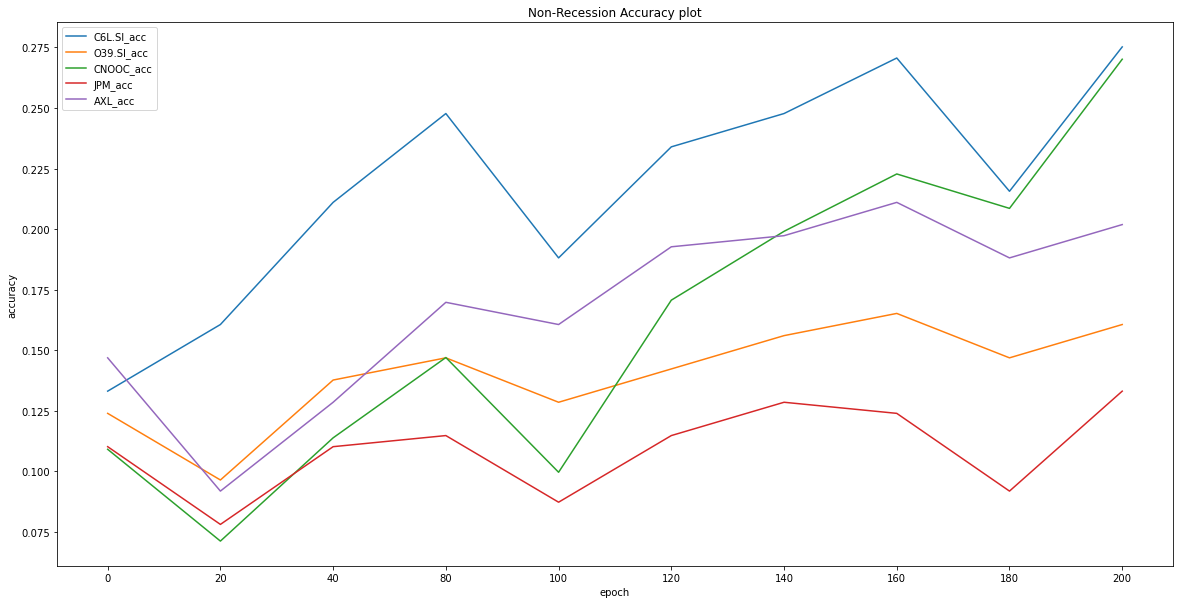

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

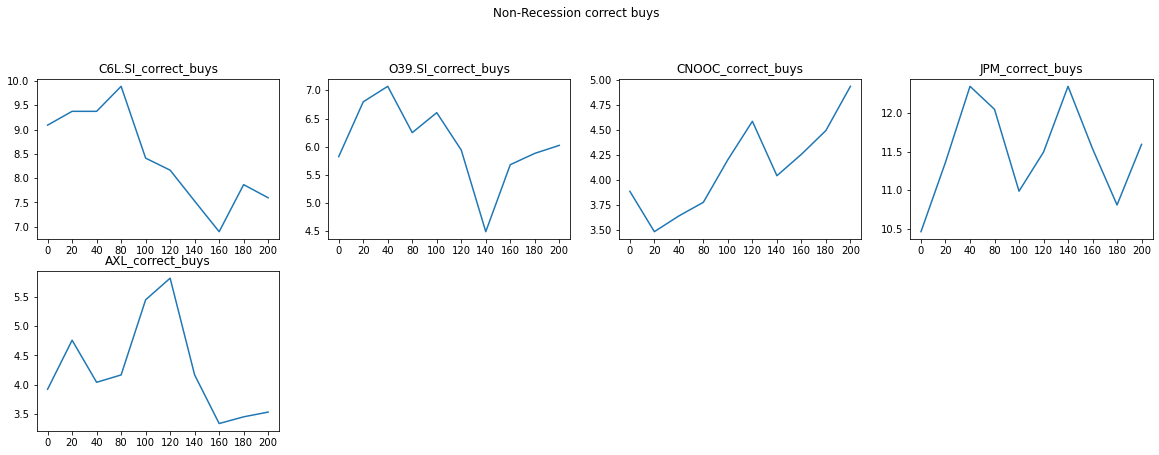

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

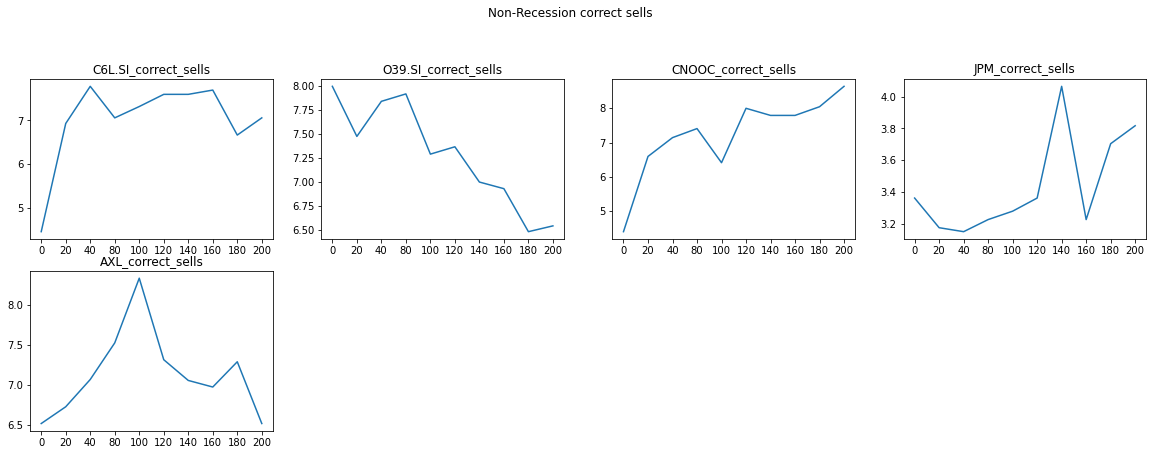

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

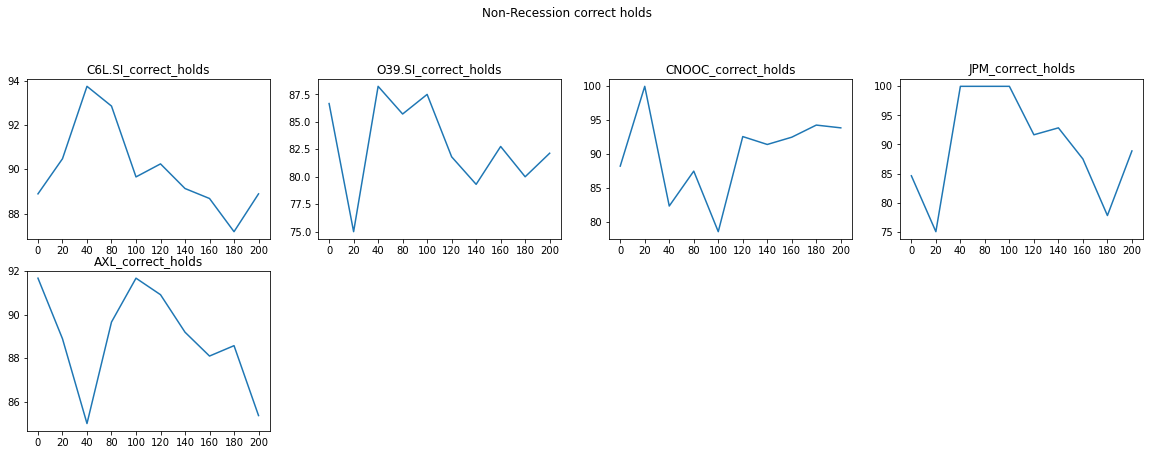

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

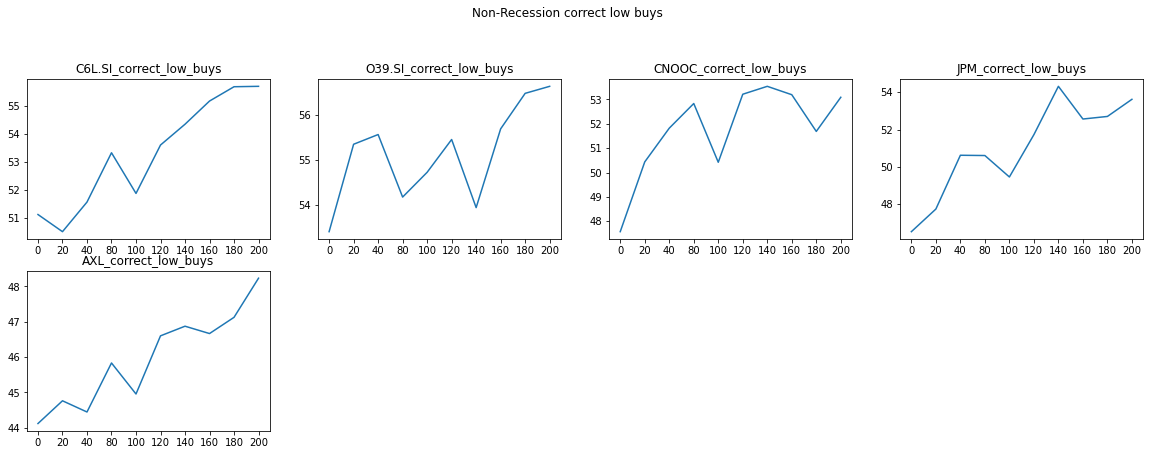

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

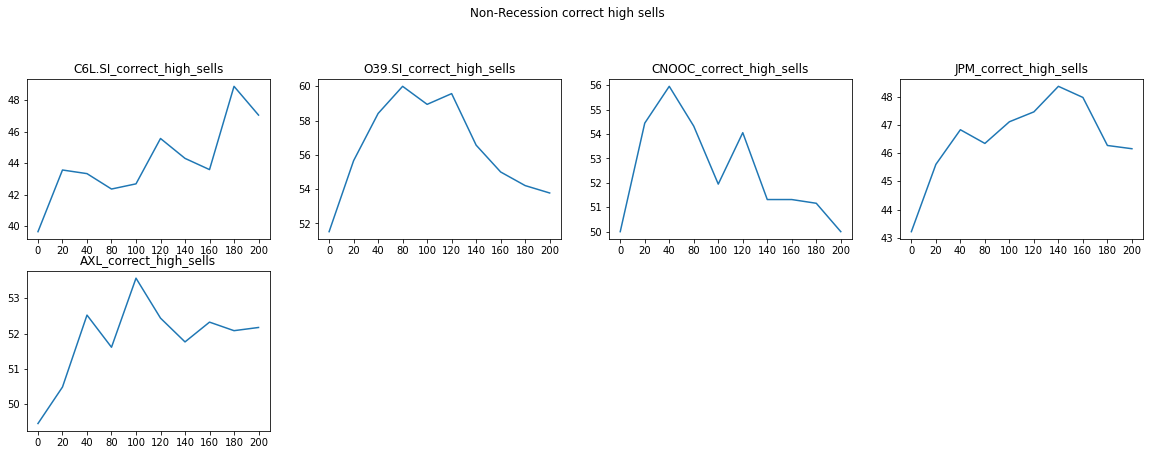

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

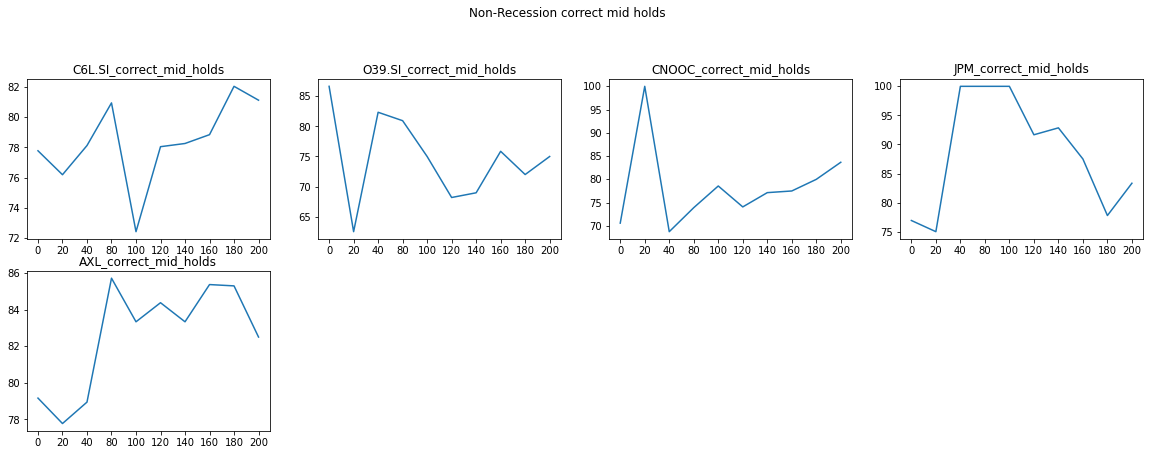

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

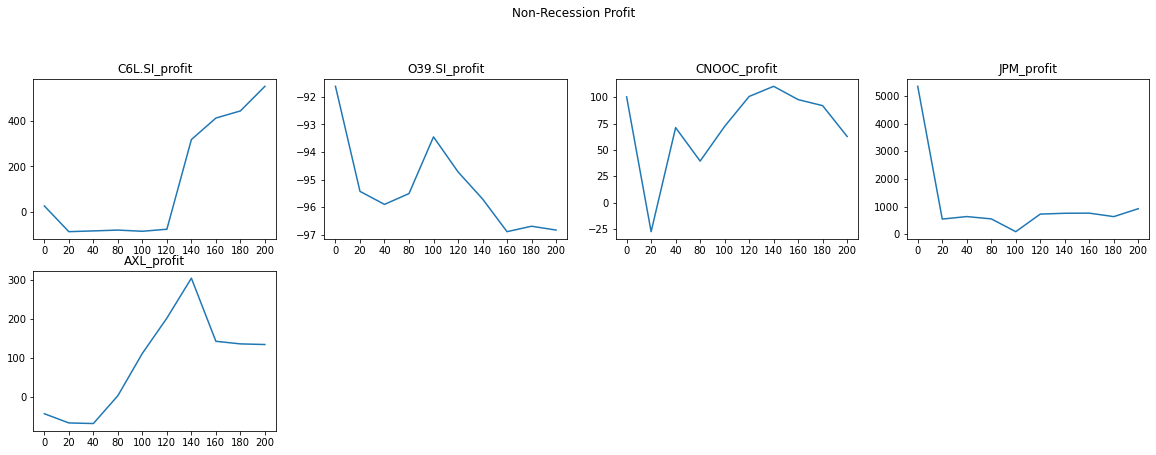

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [31]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


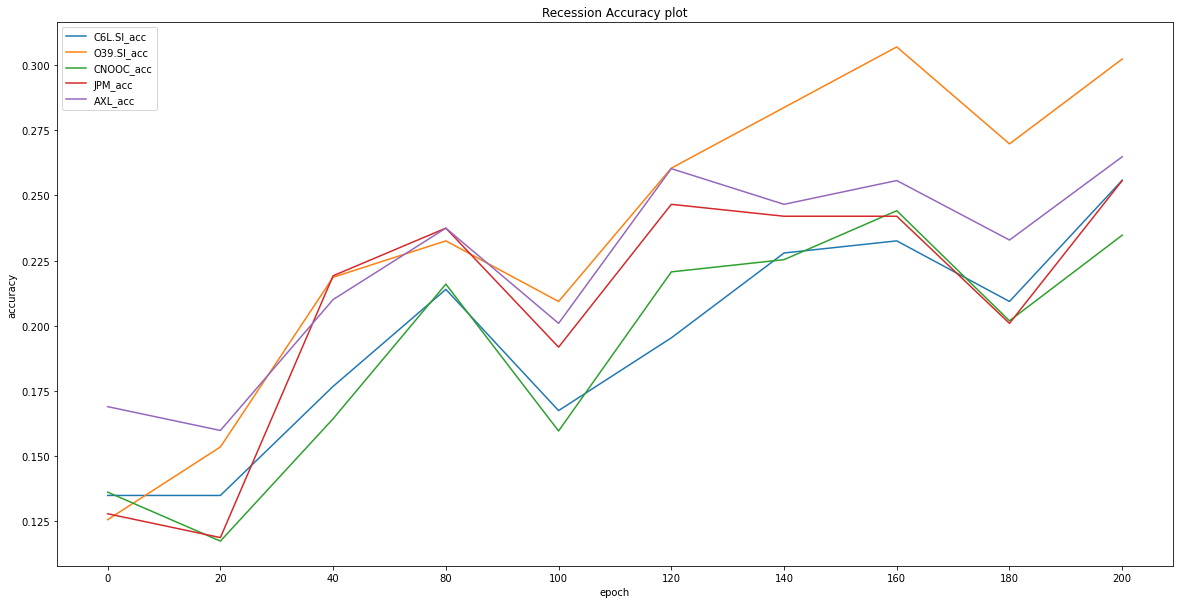

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

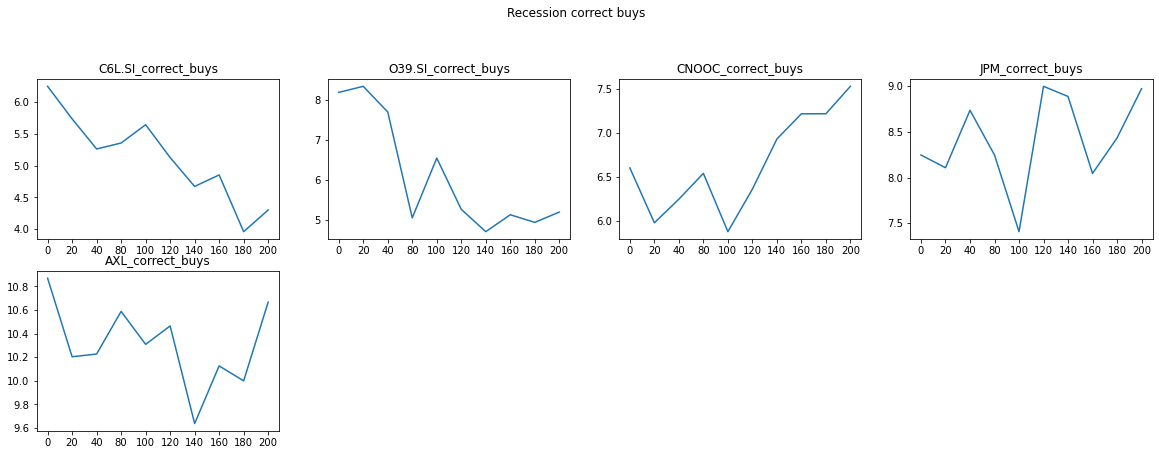

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

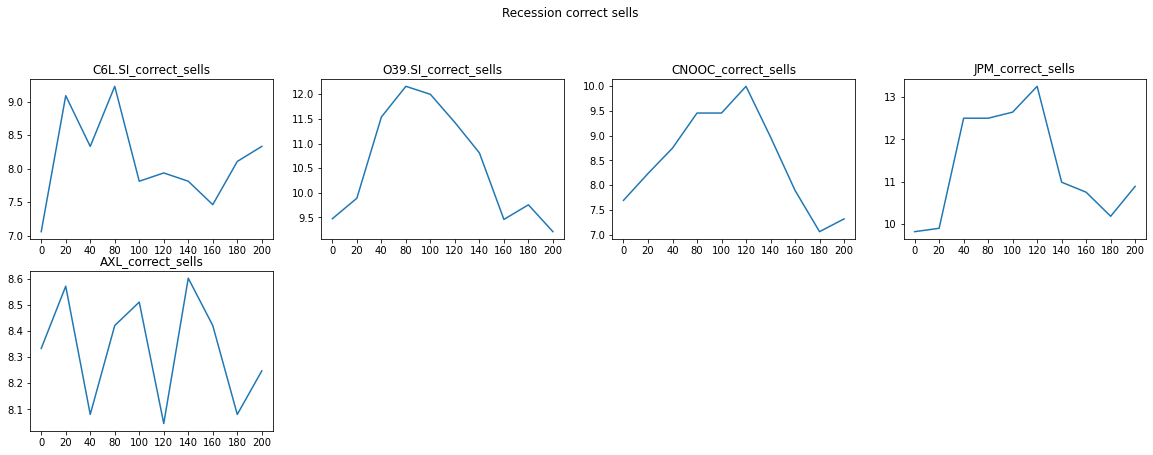

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

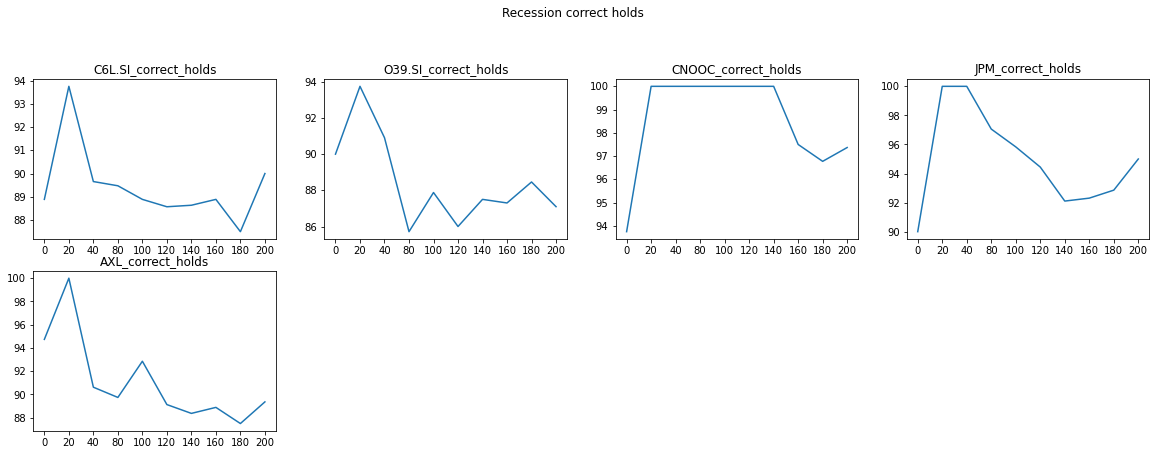

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

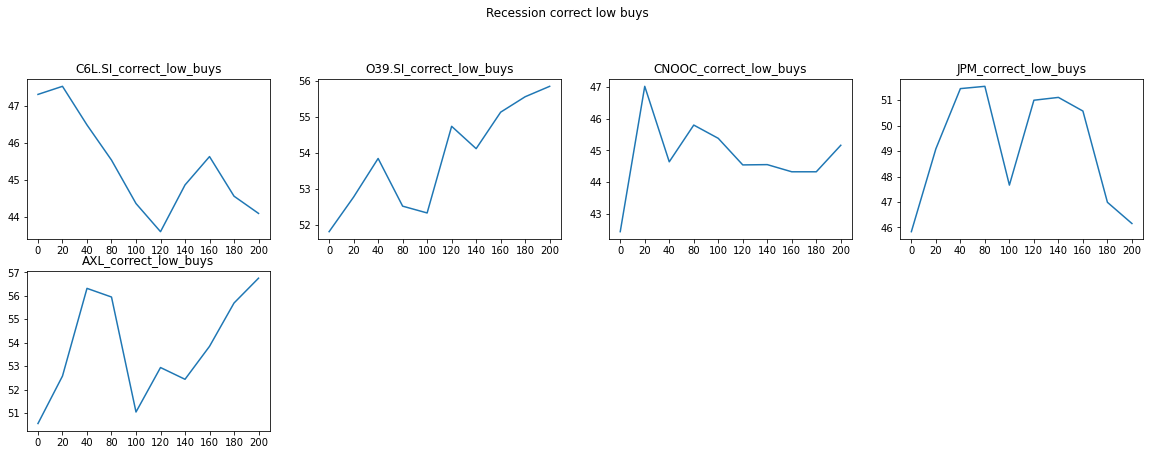

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

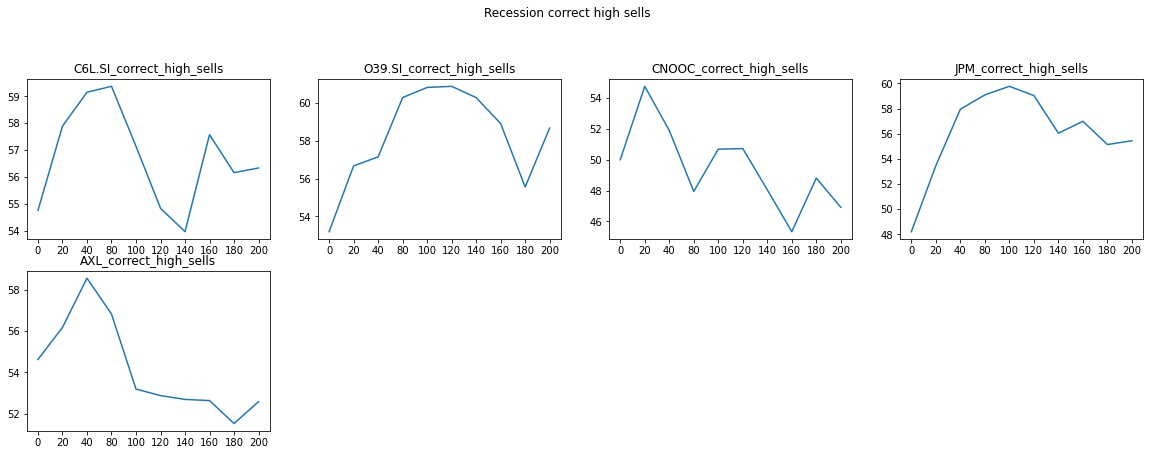

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

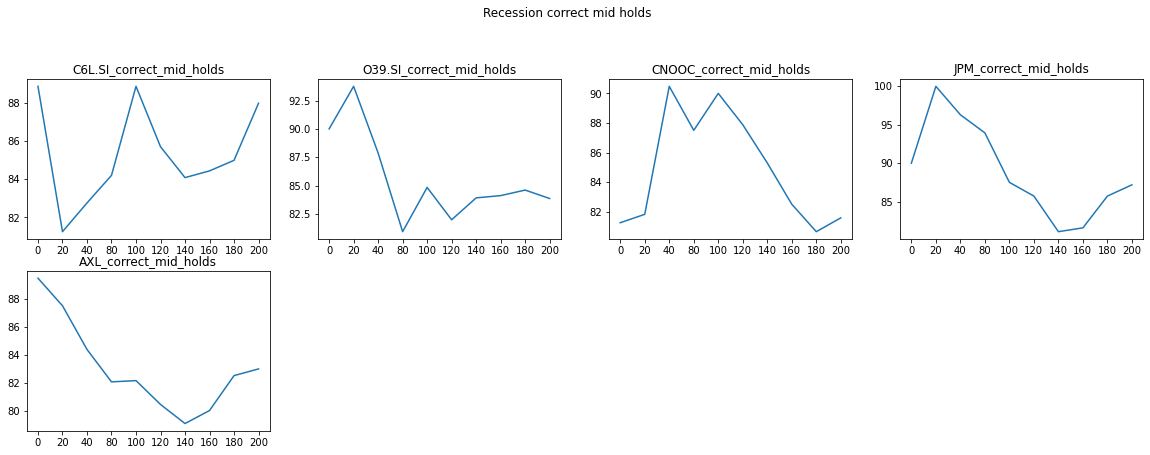

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

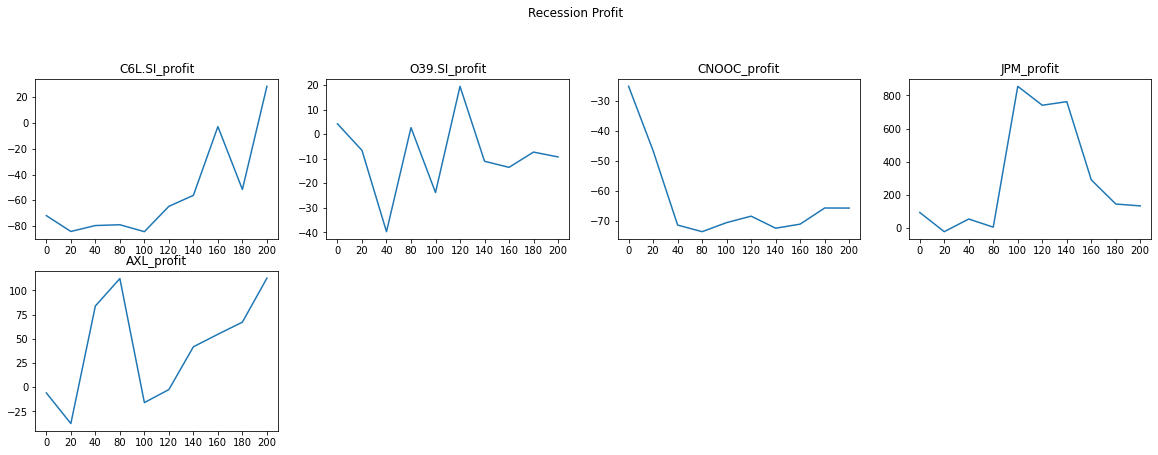

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")